## Imports

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4
import xarray as xr
from scipy.stats import pearsonr
from scipy import signal
import cartopy.crs as ccrs
# import xskillscore as xs

## Functions

In [4]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

## Loading Datasets

In [5]:
california_MW = xr.open_dataarray('mw_cal_regridded.nc')
california_O2 = xr.open_dataarray('California_O2min_regridded.nc')

In [6]:
california_MW = weighted_temporal_mean(california_MW)
california_O2 = weighted_temporal_mean(california_O2)

/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(


In [7]:
california_O2_mean = california_O2.mean(dim=('lat','lon'))[5:]
california_MW_mean = california_MW.mean(dim=('lat','lon'))[5:]

In [8]:
california_full = xr.open_dataarray('California_O2full_regridded.nc')
california_full = weighted_temporal_mean(california_full)[5:]

/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(


## Finding Volumes

In [9]:
def find_volume(region, threshold):
    vol = xr.where(region<=threshold, 1, 0)
    vol = vol.transpose('z_t','time','lat','lon')

    width = 111000*np.cos(np.deg2rad(30))
    length = 111000
    for i, depth in enumerate(vol):
        if i == 0:
            height = (vol.z_t[0]*2).values
        elif i == len(vol)-1:
            height = (vol.z_t[i]-vol.z_t[i-1]).values
        else:
            height = ((vol.z_t[i+1]-vol.z_t[i-1])/2).values
        vol[i] = width*length*height*depth
    return vol.sum(dim=('lat','lon','z_t'))

In [10]:
california_vol_45 = find_volume(california_full, 45)

california_vol_20 = find_volume(california_full, 20)

california_vol_60 = find_volume(california_full, 60)

## Plot

In [11]:
california_MW_detrended = xr.apply_ufunc(signal.detrend, california_MW_mean)
california_O2_detrended = xr.apply_ufunc(signal.detrend, california_O2_mean)

mw_adj = california_MW_detrended.rolling(time=8).mean()[7:]
O2_adj = california_O2_detrended

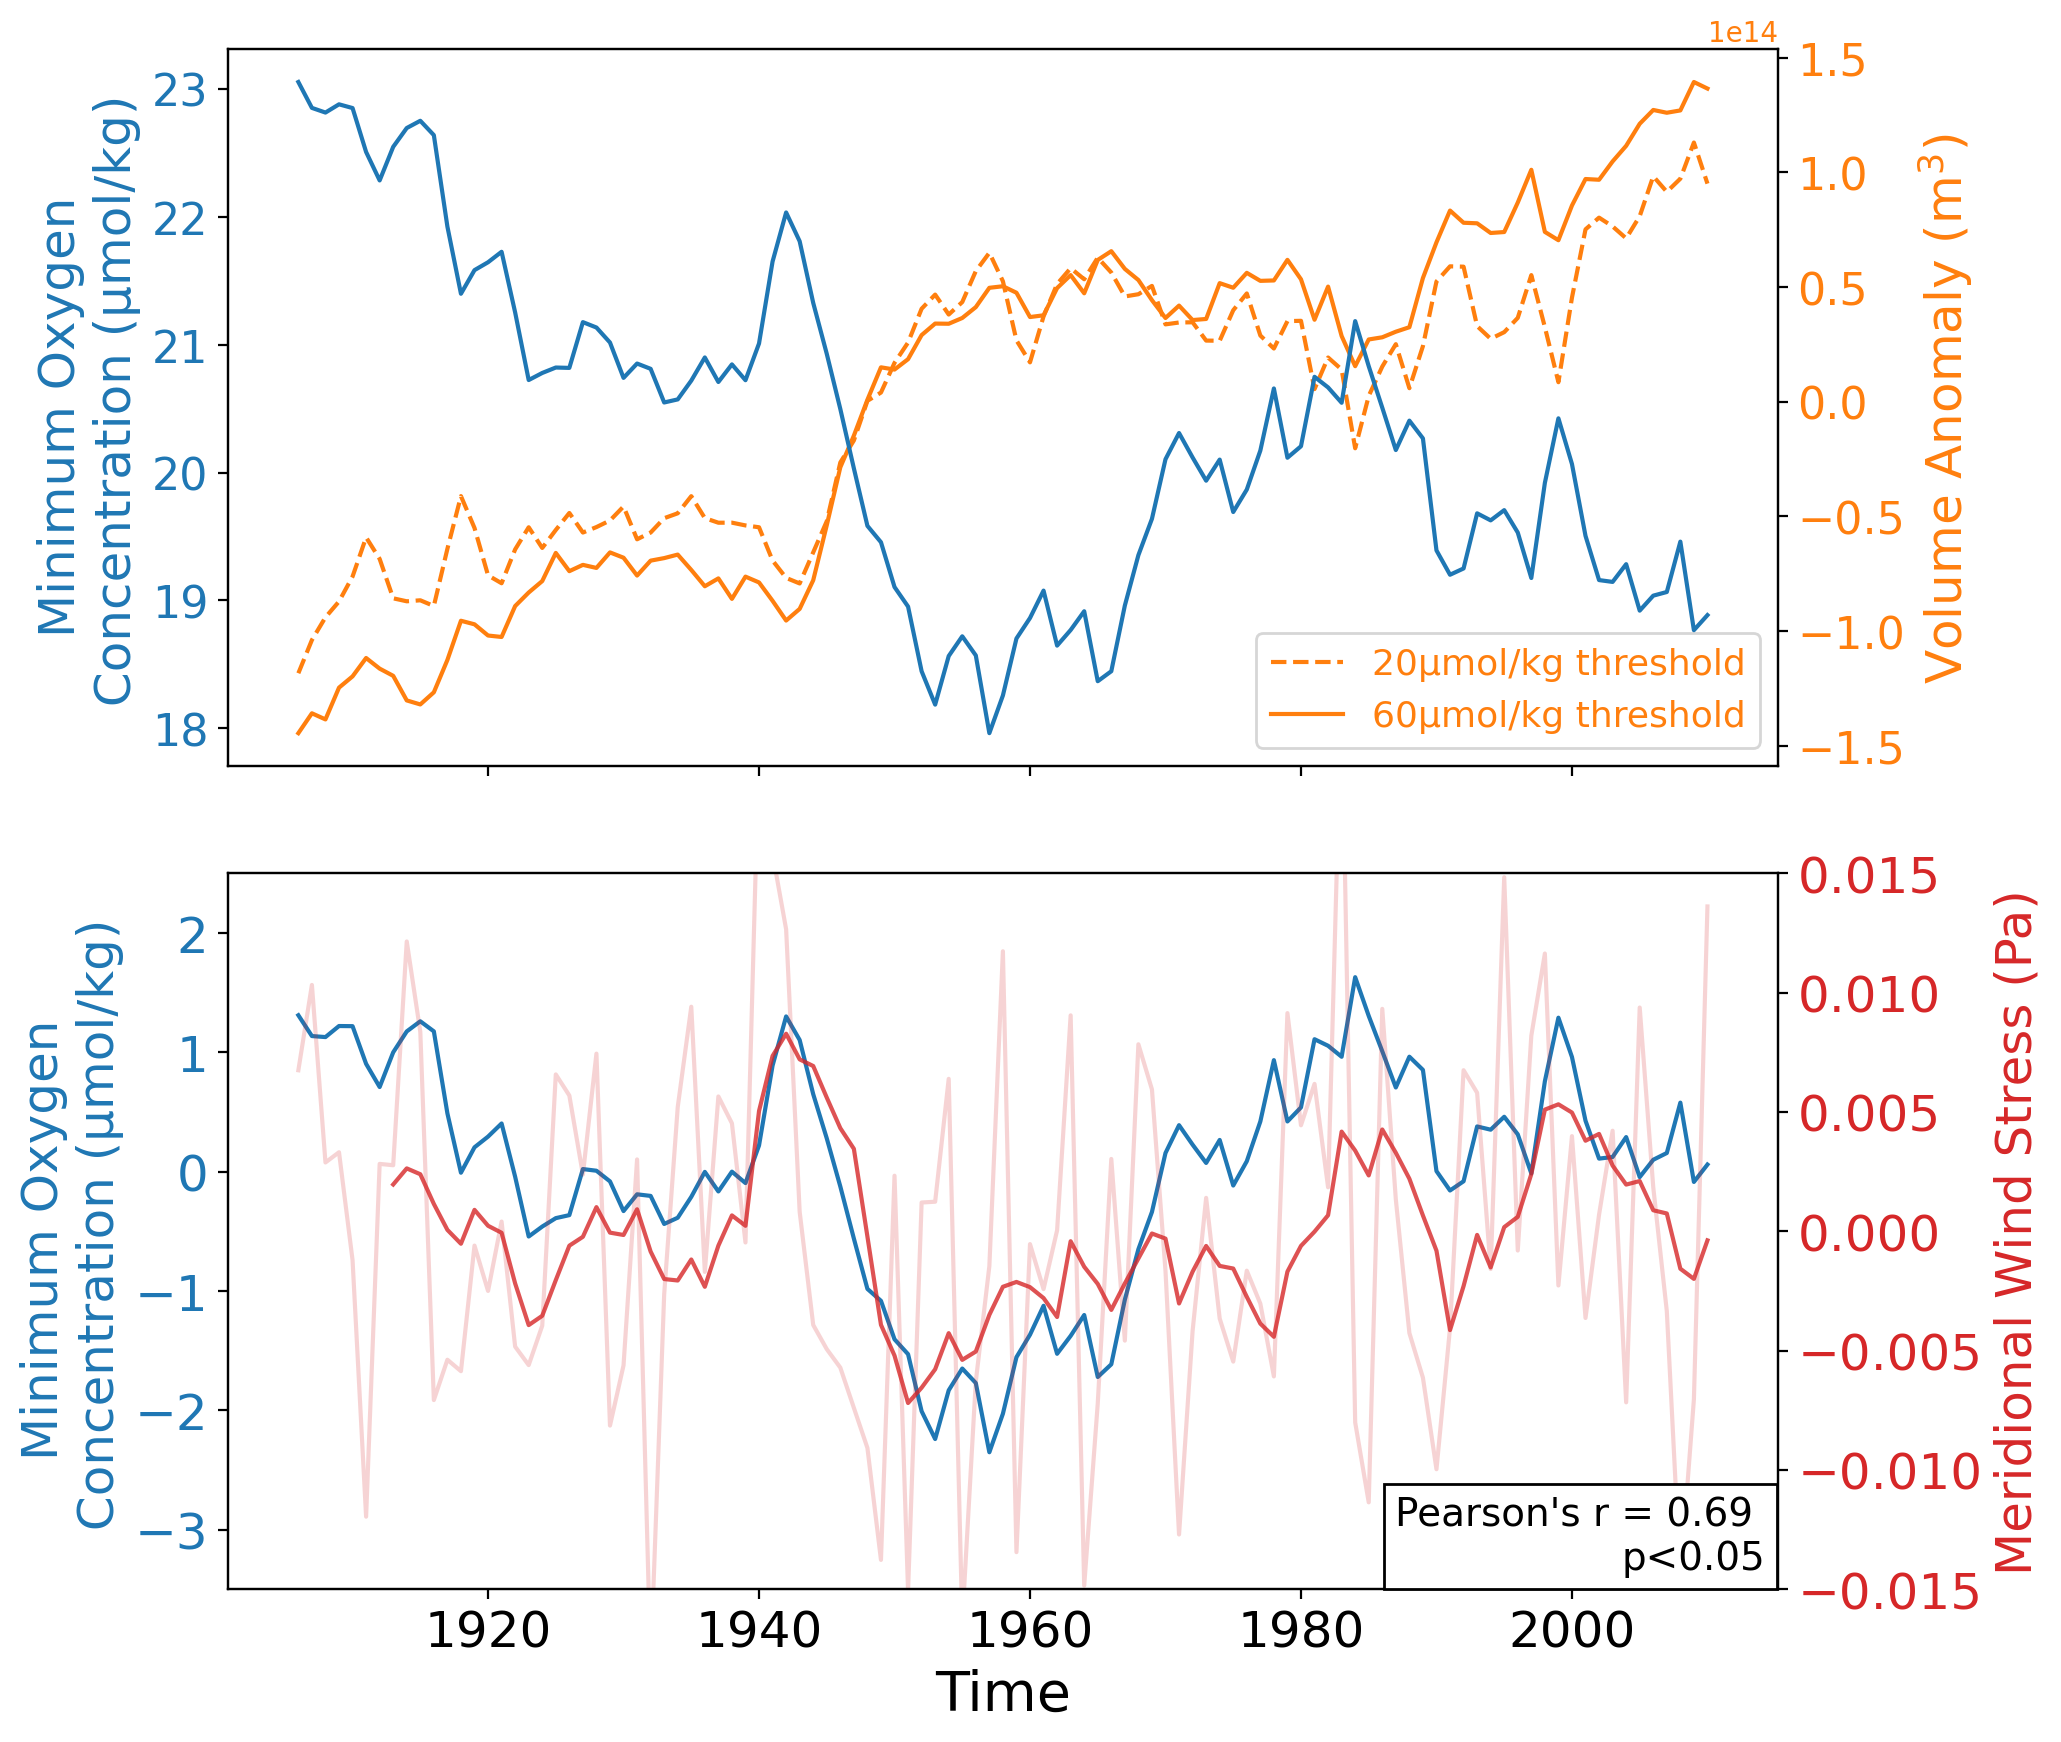

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True, dpi=200)

ax[0].plot(california_O2_mean['time.year'], california_O2_mean, color='tab:blue')
ax[0].tick_params(axis='y', labelcolor='tab:blue', labelsize=16)
ax[0].tick_params(axis='x', labelsize=16)
ax[0].set_ylabel('Minimum Oxygen \n Concentration (μmol/kg)', color='tab:blue', fontsize=18)
ax2 = ax[0].twinx()
# ax2.plot(california_O2['time.year'], california_vol_45-california_vol_45.mean(), color='tab:red')
# ax2.fill_between(california_O2['time.year'], california_vol_20-california_vol_20.mean(), 
#                  california_vol_60-california_vol_60.mean(), color='tab:orange', alpha=0.3)
ax2.plot(california_vol_20['time.year'], (california_vol_20-california_vol_20.mean()), color='tab:orange', linestyle='--', 
        label="20µmol/kg threshold")
ax2.plot(california_vol_20['time.year'], (california_vol_60-california_vol_60.mean()), color='tab:orange', 
         label="60µmol/kg threshold")
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=16)
ax2.set_ylabel('Volume Anomaly (m$^3$)', color='tab:orange', fontsize=18)

ax2.legend(labelcolor='tab:orange', fontsize=13, loc='lower right')

ax[0].set_zorder(ax2.get_zorder()+1)
ax[0].patch.set_visible(False)
ax2.patch.set_visible(True)

ax[1].plot(O2_adj['time.year'], O2_adj, color='tab:blue')
ax[1].tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
ax[1].tick_params(axis='x', labelsize=18)
ax[1].set_ylabel('Minimum Oxygen \n Concentration (µmol/kg)', color='tab:blue', fontsize=18)
ax[1].set_xlabel('Time', fontsize=20)
ax[1].set_ylim([-3.5, 2.5])
# ax[1].text(x=0.01, y=0.92, s='b)', transform=ax[1].transAxes, fontsize = 18, weight='bold')
ax2 = ax[1].twinx()
ax2.plot(california_MW_detrended['time.year'], california_MW_detrended, color='tab:red', alpha=0.2)
ax2.plot(mw_adj['time.year'], mw_adj, color='tab:red', alpha=.8)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=18)
ax2.set_ylabel('Meridional Wind Stress (Pa)', color='tab:red', fontsize=18)
ax2.set_ylim([-0.015, 0.015])

ax2.text(x=0.992, y=0.0282, s='Pearson\'s r = 0.69 \np<0.05' , transform=ax[1].transAxes, fontsize=14, 
        horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', zorder=10))

plt.subplots_adjust(hspace=0.15)

plt.show()

## Statistical Testing

In [12]:
rs = np.zeros(12)
ps = np.zeros(12)
for i in range(1,13):
    rs[i-1] = xs.pearson_r(california_MW_detrended.rolling(time=i).mean()[i-1:], O2_adj[i-1:])
    ps[i-1] = xs.pearson_r_eff_p_value(california_MW_detrended.rolling(time=i).mean()[i-1:], O2_adj[i-1:])

In [13]:
california_vol_20_detrended = xr.apply_ufunc(signal.detrend, california_vol_20)
california_vol_60_detrended = xr.apply_ufunc(signal.detrend, california_vol_60)

In [14]:
xs.pearson_r(california_O2_detrended, california_vol_20_detrended).item()

-0.8307010911897293

In [15]:
xs.pearson_r_eff_p_value(california_O2_detrended, california_vol_20_detrended).item()

0.0029142193237455226

In [16]:
xs.pearson_r(california_O2_detrended, california_vol_60_detrended).item()

-0.8512514329456985

In [17]:
xs.pearson_r_eff_p_value(california_O2_detrended, california_vol_60_detrended).item()

0.015103257252148002

In [20]:
xs.pearson_r(mw_adj, O2_adj[7:]).item()

0.685079426562509

In [21]:
xs.pearson_r_eff_p_value(mw_adj, O2_adj[7:]).item()

0.041708442817163204